In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from transformers import AdamW, get_scheduler

from jre_utils.datapath import (
    processed_pretraining_data_paths,
    pretraining_data_paths,
    pretrained_weights_paths,
)
from jre_utils.data import TimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import (
    evaluate,
    train,
    EarlyStopper,
)
from jre_utils.metrics import MSELossWeighted

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

/Users/diab/Desktop/japan_re/venv38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = "etth1"
df = pd.read_csv(pretraining_data_paths[dataset])
date_time = pd.to_datetime(df.pop("date"), format='%Y/%m/%d %H:%M')

In [3]:
df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...
17415,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


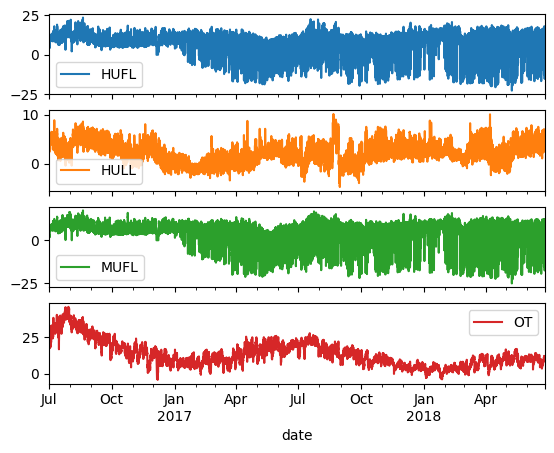

In [4]:
plot_cols = ['HUFL', 'HULL', 'MUFL', 'OT']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HUFL,17420.0,7.375141,7.067744,-22.705999,5.827,8.774,11.788,23.643999
HULL,17420.0,2.242242,2.042342,-4.756000,0.737,2.210,3.684,10.114000
MUFL,17420.0,4.300239,6.826978,-25.087999,3.296,5.970,8.635,17.341000
MULL,17420.0,0.881568,1.809293,-5.934000,-0.284,0.959,2.203,7.747000
LUFL,17420.0,3.066062,1.164506,-1.188000,2.315,2.833,3.625,8.498000
LULL,17420.0,0.856932,0.599552,-1.371000,0.670,0.975,1.218,3.046000
OT,17420.0,13.324672,8.566946,-4.080000,6.964,11.396,18.079,46.007000


In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.9)]
val_df = df[int(n*0.9):]

num_features = df.shape[1]

In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

In [8]:
train_df

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,-0.251240,-0.067267,-0.443884,-0.205290,1.022454,0.875300,1.887159
1,-0.270936,-0.034257,-0.460141,-0.225046,0.969893,0.926536,1.579167
2,-0.349718,-0.199306,-0.492502,-0.264010,0.655386,0.673662,1.579167
3,-0.359566,-0.100276,-0.492502,-0.244253,0.681236,0.774481,1.271288
4,-0.320175,-0.100276,-0.460141,-0.205290,0.733798,0.774481,0.923788
...,...,...,...,...,...,...,...
15673,1.255036,0.064772,0.986853,-0.166326,1.180139,0.572842,-0.939649
15674,1.077922,-0.100276,0.873512,-0.225046,1.127577,0.422440,-1.018554
15675,1.156557,-0.100276,0.986853,-0.322181,0.944043,0.272038,-0.994871
15676,0.900661,-0.561920,0.760020,-0.634439,0.969893,0.321621,-0.963332


In [9]:
train_df.to_csv(processed_pretraining_data_paths[dataset]["train"], index=False)
val_df.to_csv(processed_pretraining_data_paths[dataset]["eval"], index=False)

In [10]:
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [34]:
BATCH_SIZE = 64
window_length = 10
shift = 1

feature_columns = df.columns
# feature_columns = ["OT"]

train_dataset = TimeSeriesDataset(
    train_df,
    metrics=["OT"],
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)
val_dataset = TimeSeriesDataset(
    val_df,
    metrics=["OT"],
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)

In [35]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
eval_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [36]:
for i, sample in enumerate(train_dataloader):
    if i == 0:
        print(i, sample["window"].shape, sample["target"].shape)
        break

0 torch.Size([64, 10, 7]) torch.Size([64, 1])


In [37]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [38]:
n_features = len(feature_columns)
d_model = 128
d_hid = 256
nlayers = 4
nhead = 4
dropout = 0.1
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    device=device,
)
model = model.to(device)


In [39]:
model.eval()
mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        print("Loss:", loss.item())

        if i == 0:
            break

torch.Size([64, 10, 7]) torch.Size([64, 10]) torch.Size([64, 1]) torch.Size([64, 1])
torch.Size([64, 1])
Loss: 0.768660306930542


In [40]:
learning_rate = 1e-4
num_epochs = 20

In [41]:
train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [42]:
num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    if early_stopper.early_stop(eval_loss):
        print(f"Early stopping at epoch {epoch}")
        break


progress_bar.close()

100%|██████████| 4900/4900 [07:14<00:00, 11.28it/s]


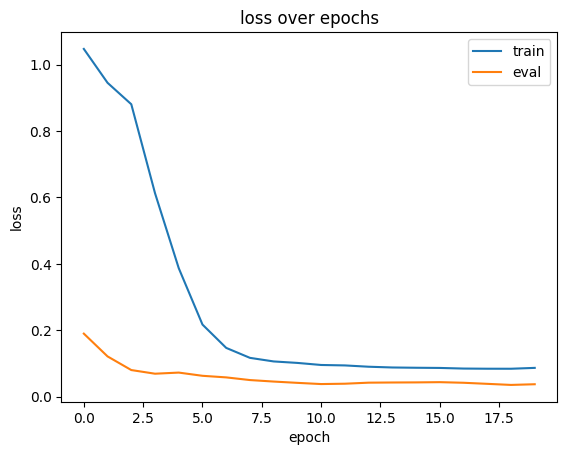

In [43]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

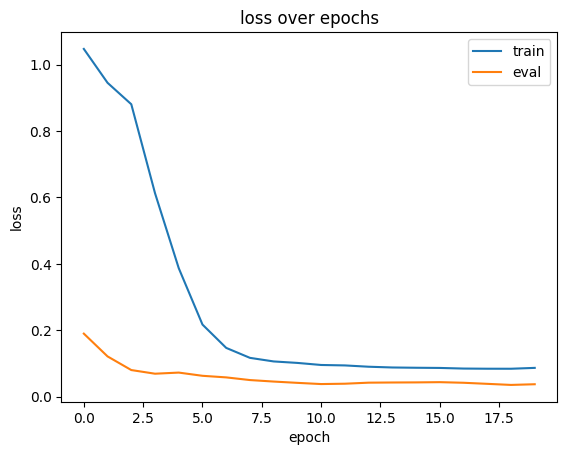

In [44]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

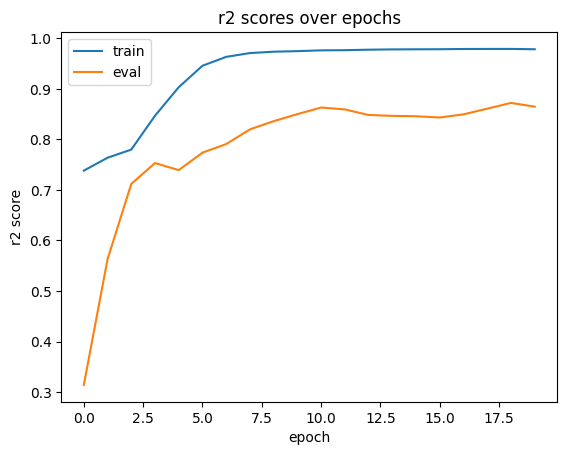

In [45]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()